In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.3.3
scipy version: 1.5.2


In [3]:
import json
import corner

In [4]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

In [5]:
df.columns

Index(['filename', 'date', 'obj', 'bjd', 'rv', 'e_rv', 'exptime', 'progid',
       'airm', 'drift', 'bis', 'fwhm', 's_hk', 'e_s_hk', 'snr'],
      dtype='object')

2457588.76726555

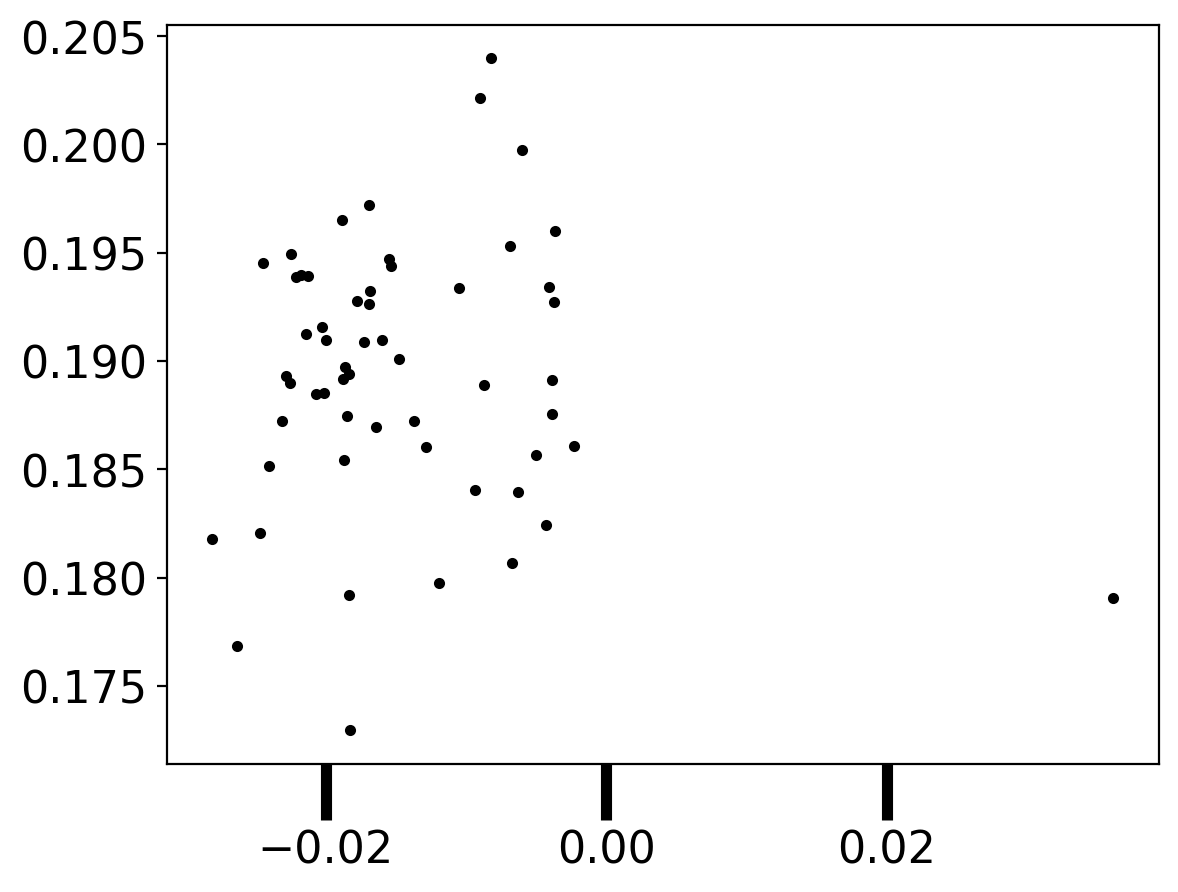

In [6]:
plt.plot(df.bis, df.s_hk, 'k.')
df.bjd[np.argmax(df.bis)]

In [7]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("bjd")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
#bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)
#fwhm_rv = np.ascontiguousarray((df.fwhm - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)
bis_rv = np.ascontiguousarray(df.bis, dtype=np.float64)
fwhm_rv = np.ascontiguousarray(df.fwhm, dtype=np.float64)
shk = np.ascontiguousarray(df.s_hk, dtype=np.float64)
yerr_shk = np.ascontiguousarray(df.e_s_hk, dtype=np.float64)
#crx = np.ascontiguousarray(df.CRX, dtype=np.float64)
#crx_rv = np.copy(crx) # hack for functions
#yerr_crx = np.ascontiguousarray(df.CRXerr, dtype=np.float64)

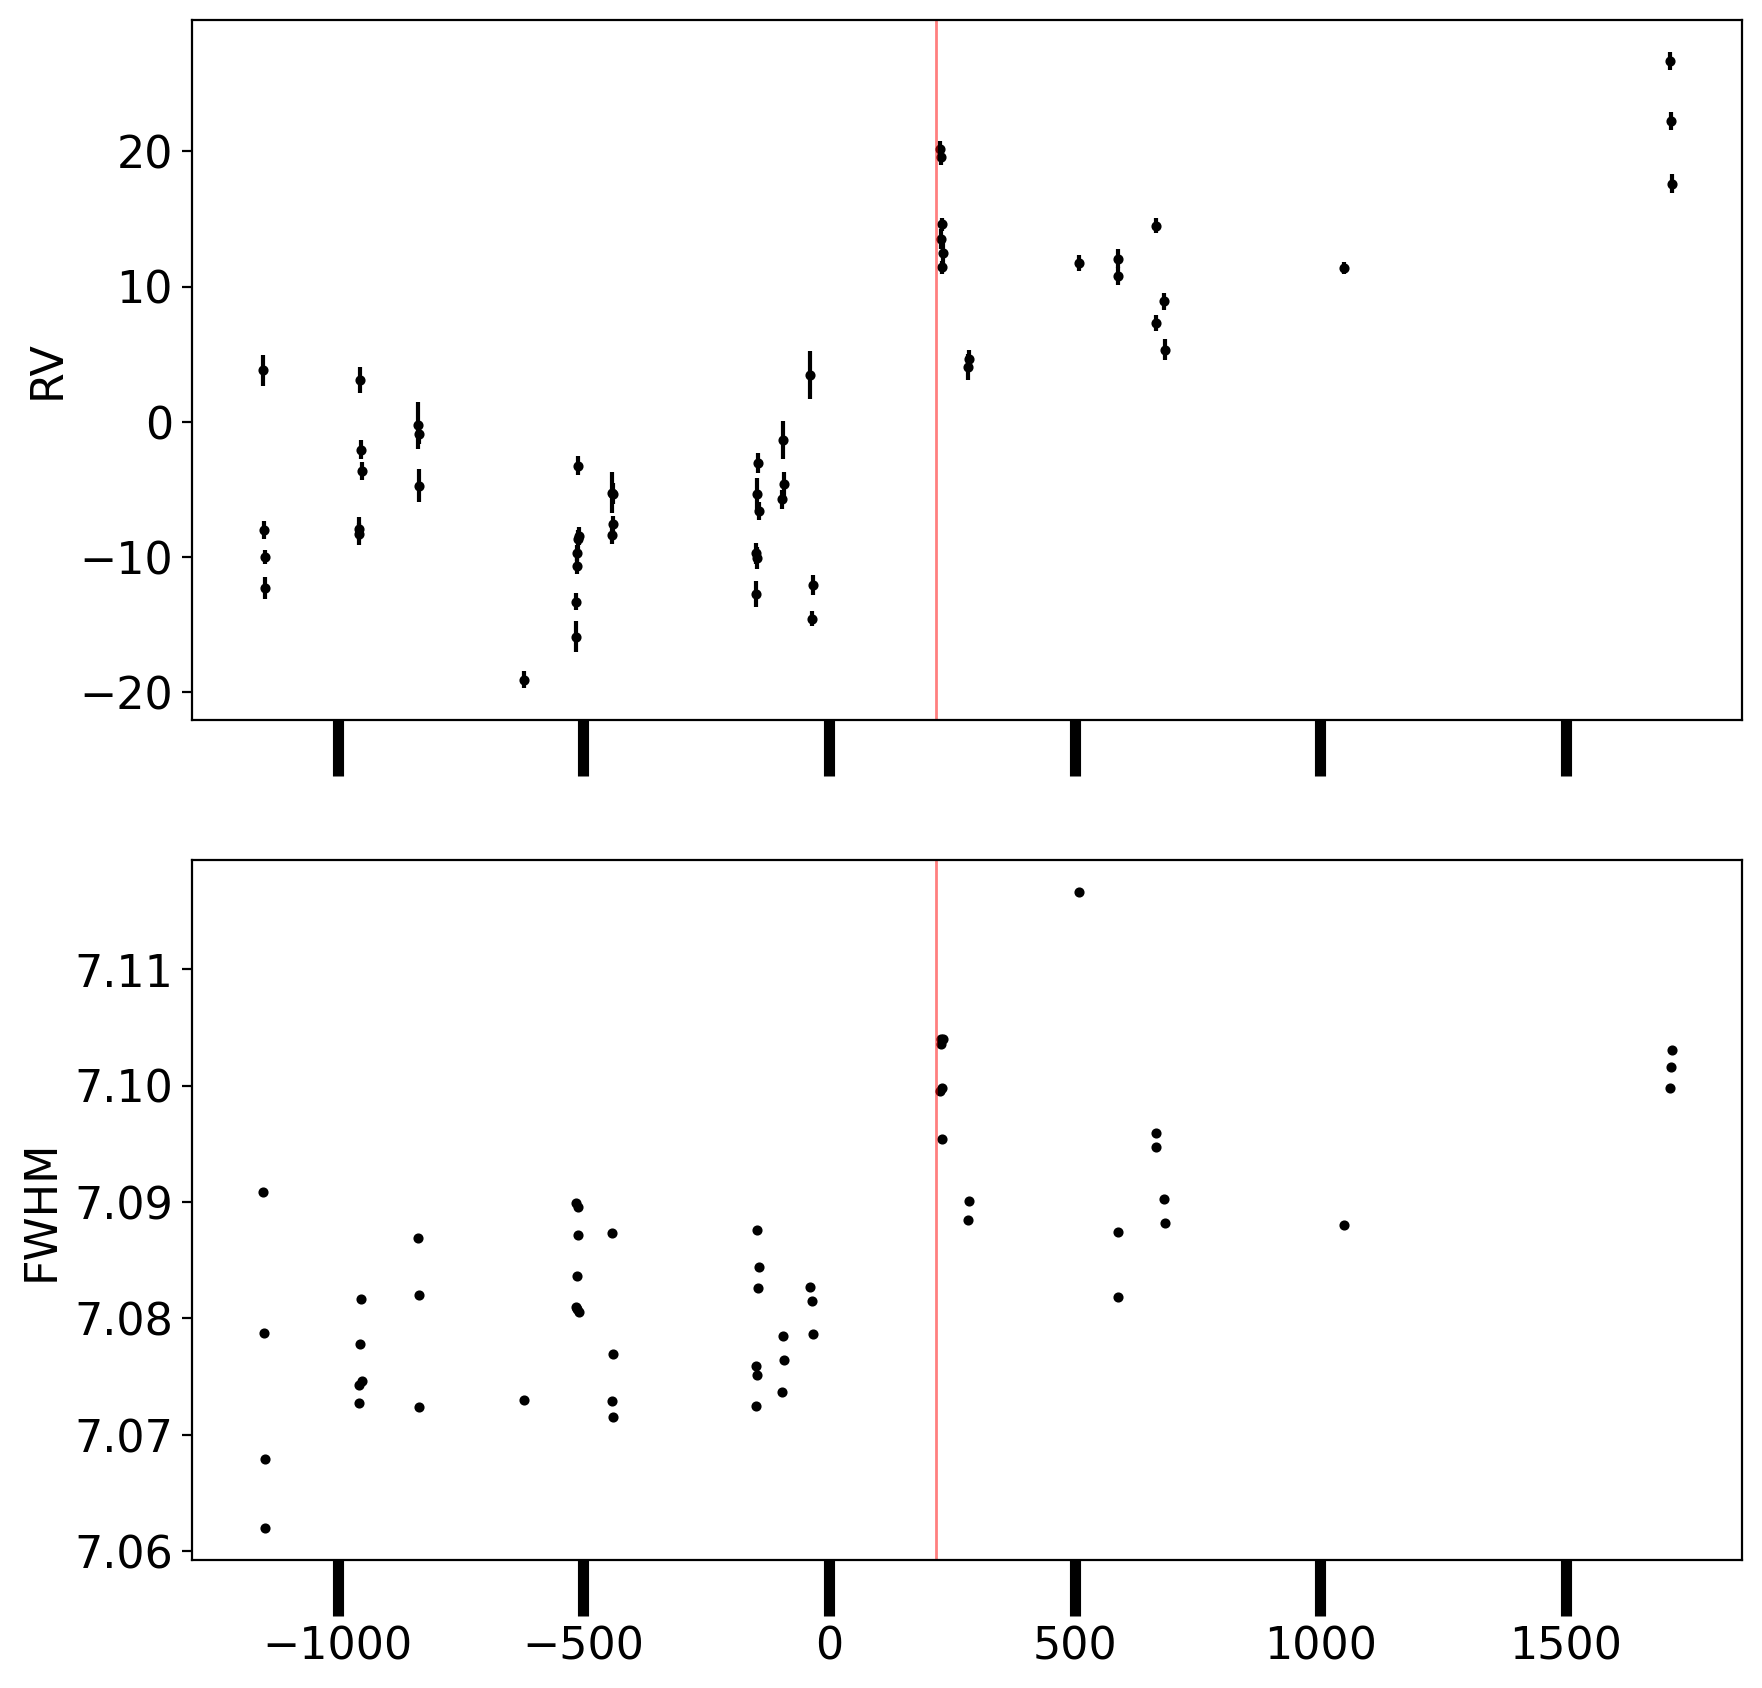

In [8]:
fig, (ax1,ax3) = plt.subplots(2,1, figsize=(10,10), sharex=True)
ax1.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
ax1.scatter(x_rv, y_rv, c='k', s=7)
ax1.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax1.set_ylabel('RV')

ax3.scatter(x_rv, fwhm_rv, c='k', s=7)
ax3.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax3.set_ylabel('FWHM');

In [9]:
y_rv_guess = np.copy(y_rv)
y_rv_guess[pug] -= 15.4
y_rv_guess -= np.median(y_rv_guess)

rms = 5.91 m/s


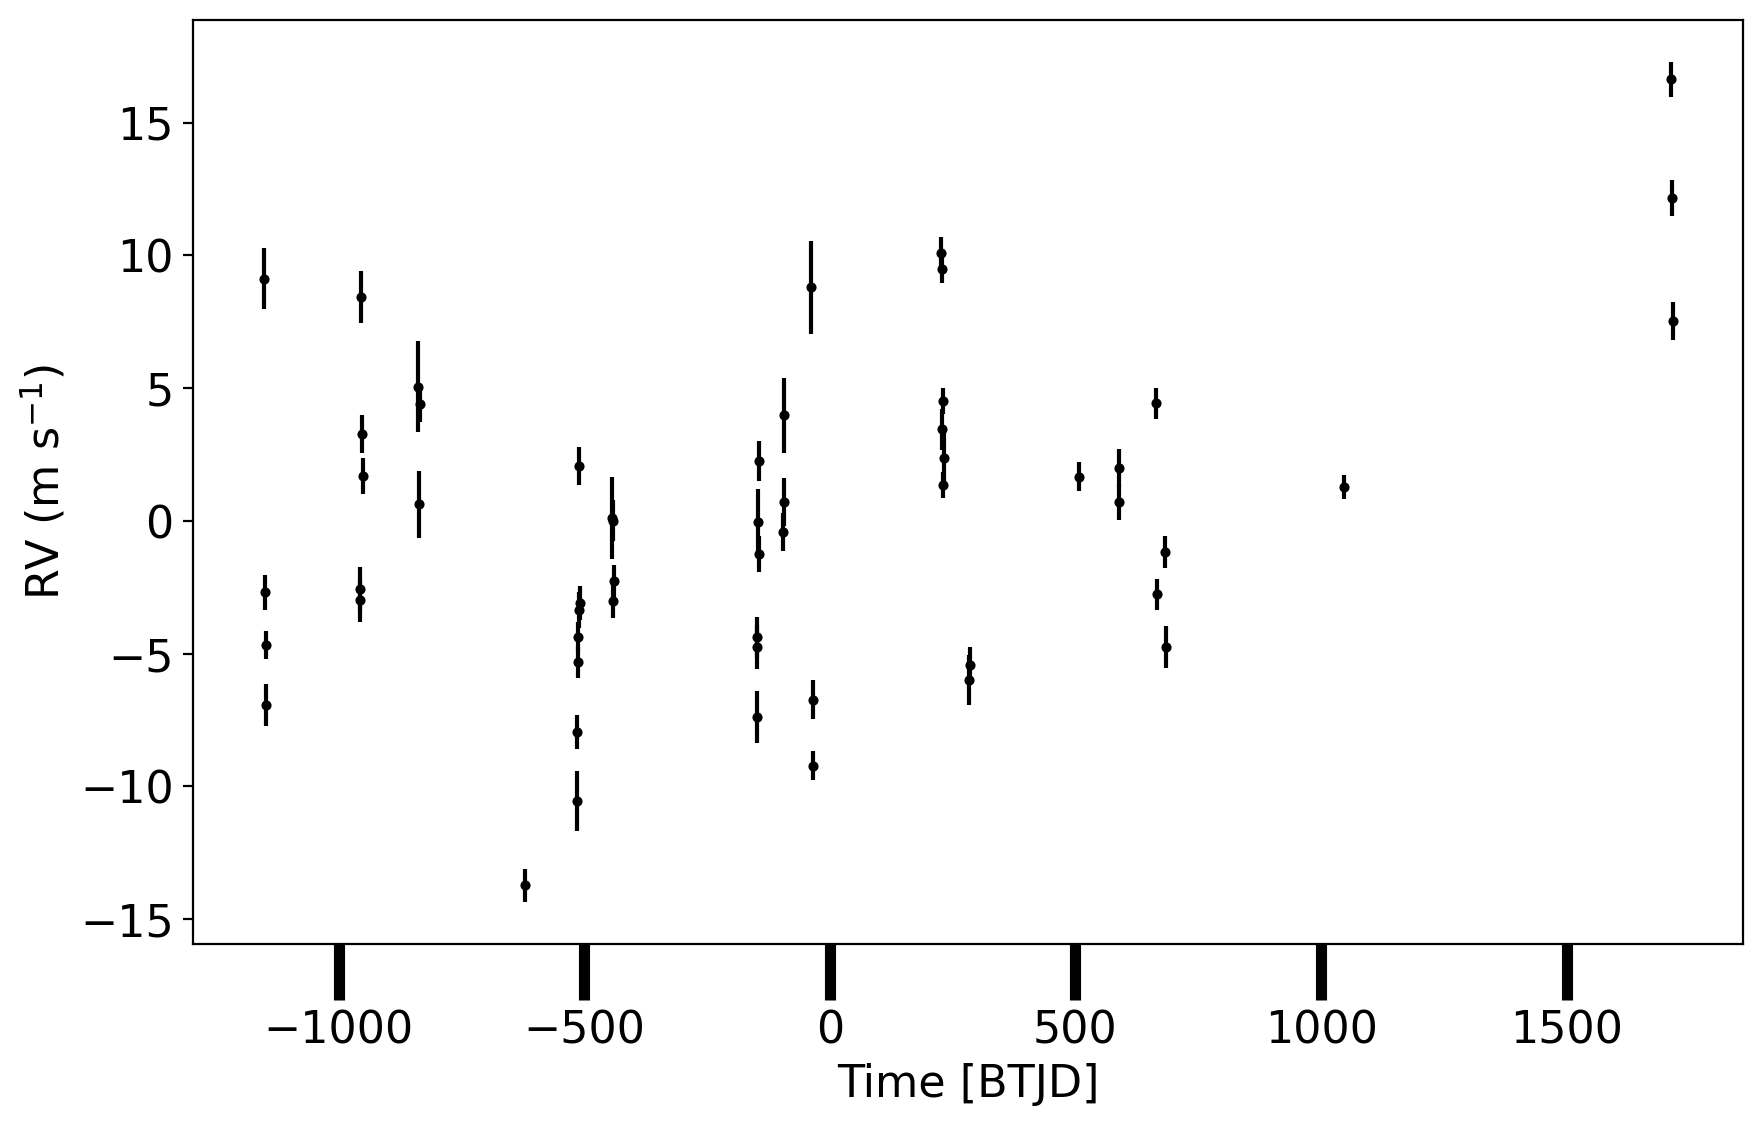

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.errorbar(x_rv, y_rv_guess, yerr=yerr_rv, fmt=",k", zorder=-10)
ax.scatter(x_rv, y_rv_guess, c="k", s=7)
#plt.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax.set_xlabel("Time [BTJD]")
ax.set_ylabel(r'RV (m s$^{-1}$)')
plt.savefig(plot_dir+'rvs.png')
print("rms = {0:.2f} m/s".format(np.std(y_rv_guess)));

peaks at:
34.60 days
34.52 days
99.98 days
1.09 days
99.29 days
59.15 days
1.01 days
1.09 days
1.01 days
504.36 days


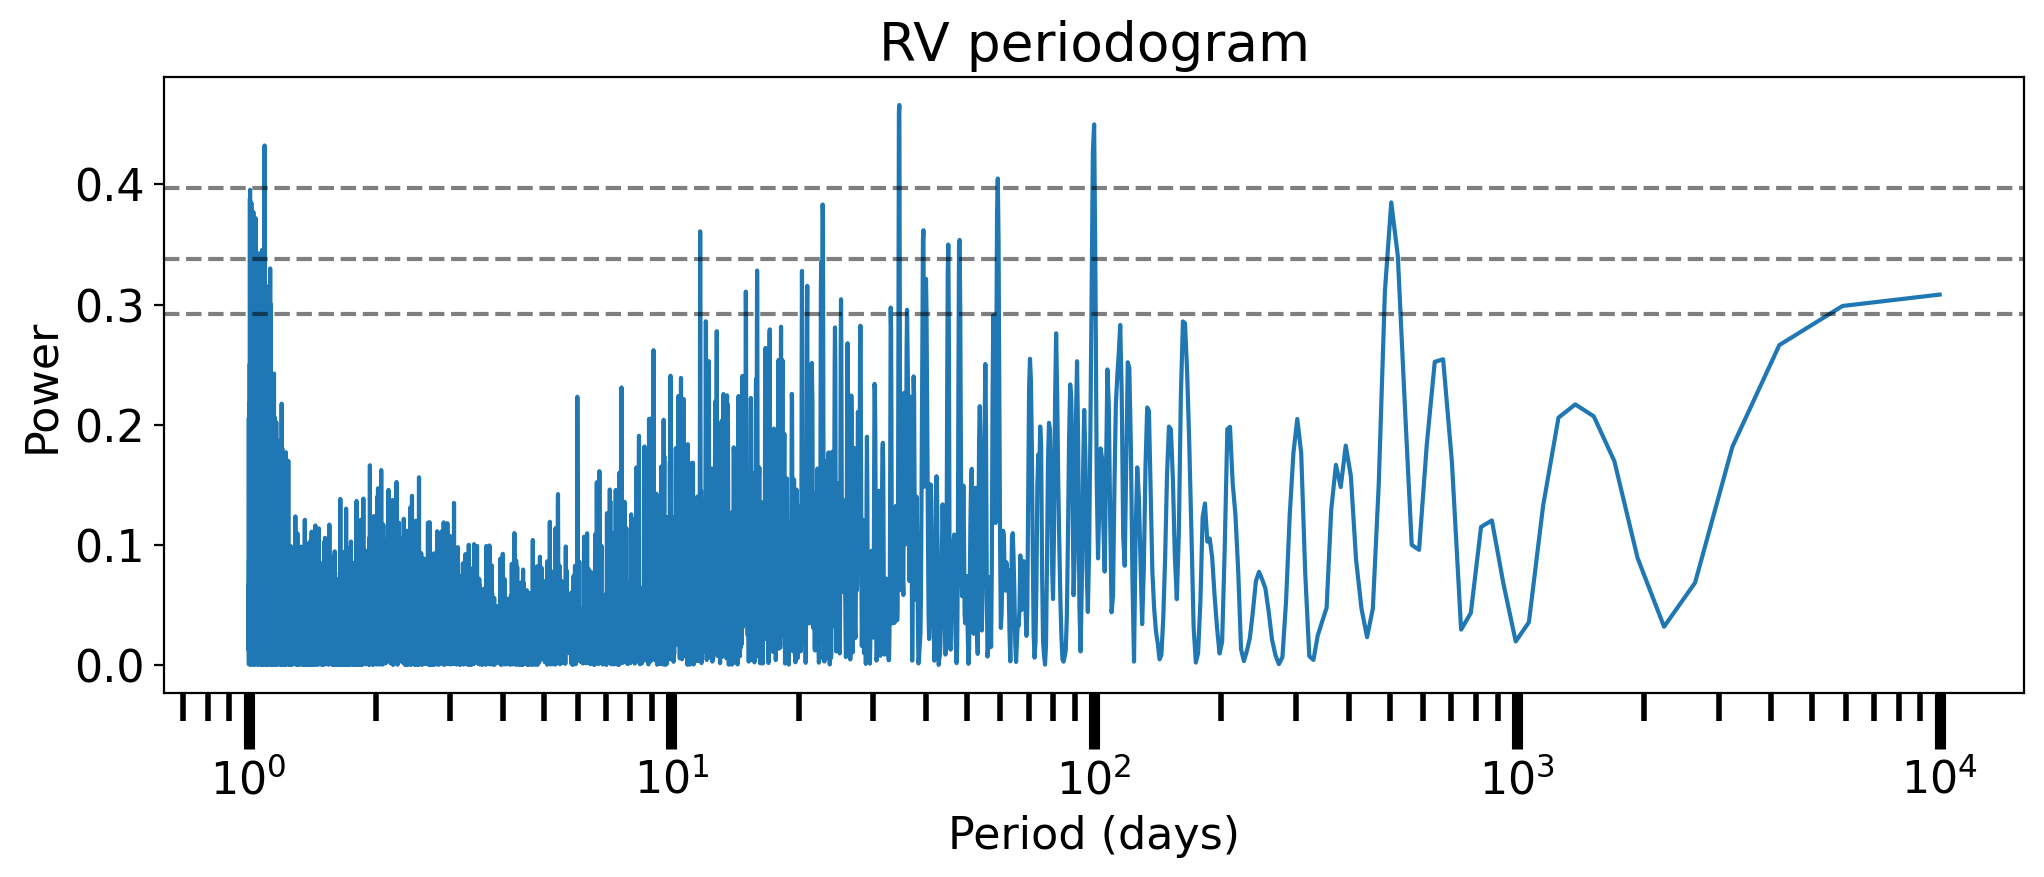

In [11]:
from astropy.timeseries import LombScargle
ls = LombScargle(x_rv, y_rv_guess, yerr_rv)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5, ls='--')
ax.set_xscale('log')
ax.set_title('RV periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

Pearson R is 0.3947 with a false-alarm probability of 0.0029


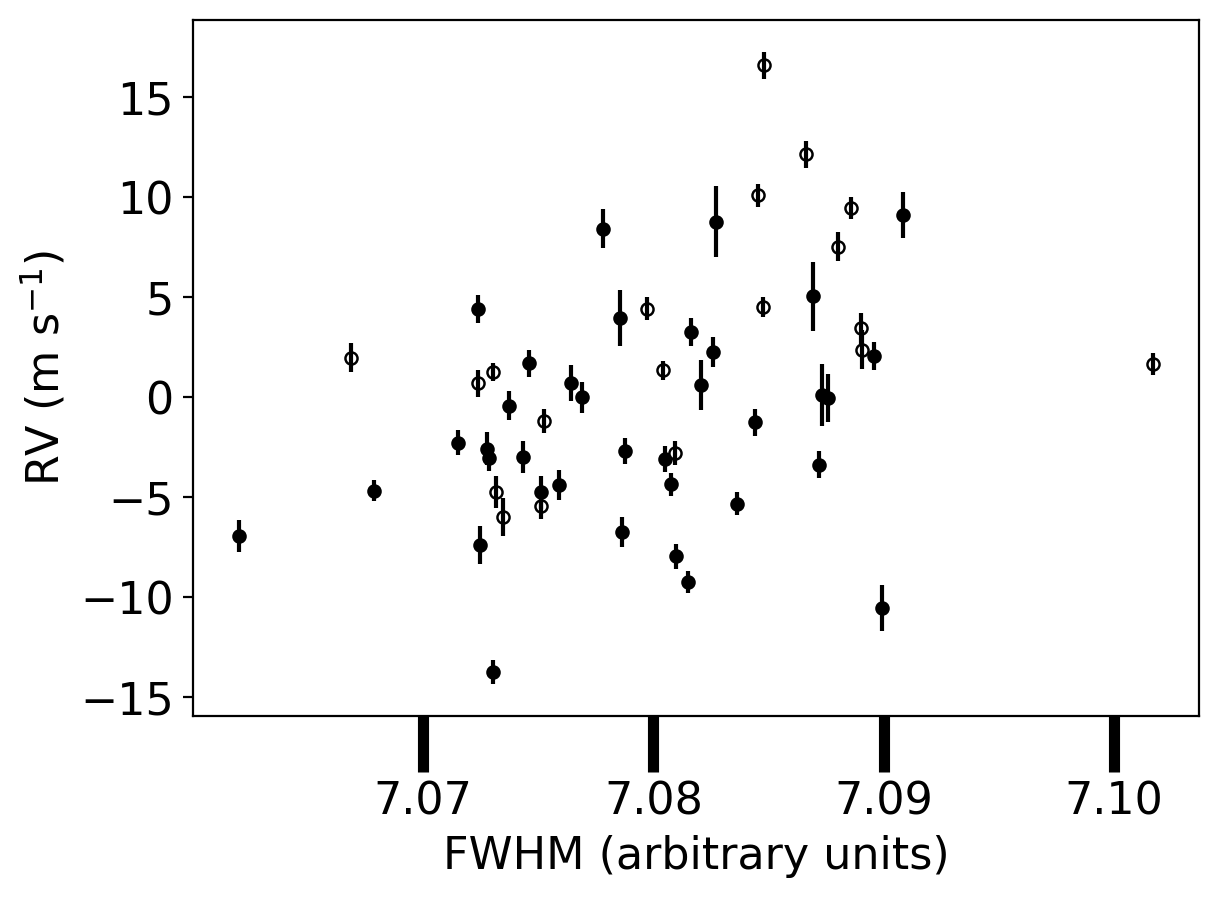

In [12]:
fwhm_rv_guess = np.copy(fwhm_rv)
fwhm_rv_guess[pug] -= 0.015

plt.errorbar(fwhm_rv_guess, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(fwhm_rv_guess, y_rv_guess, c='k', s=18)
plt.scatter(fwhm_rv_guess[pug], y_rv_guess[pug], c='w', s=6)
plt.xlabel('FWHM (arbitrary units)')
plt.ylabel(r'RV (m s$^{-1}$)')

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(fwhm_rv_guess, y_rv_guess)))

#mask = (fwhm_rv_guess > 1.8) | (fwhm_rv_guess > 0) & (y_rv_guess < -15)
#plt.scatter(fwhm_rv_guess[mask], y_rv_guess[mask], c='r', s=20);

plt.tight_layout()
plt.savefig(plot_dir+'rv_fwhm_corr.pdf')

peaks at:
30.94 days
30.88 days
1.03 days
1.03 days
30.81 days
31.01 days
1.03 days
1.03 days
1.06 days
9.60 days


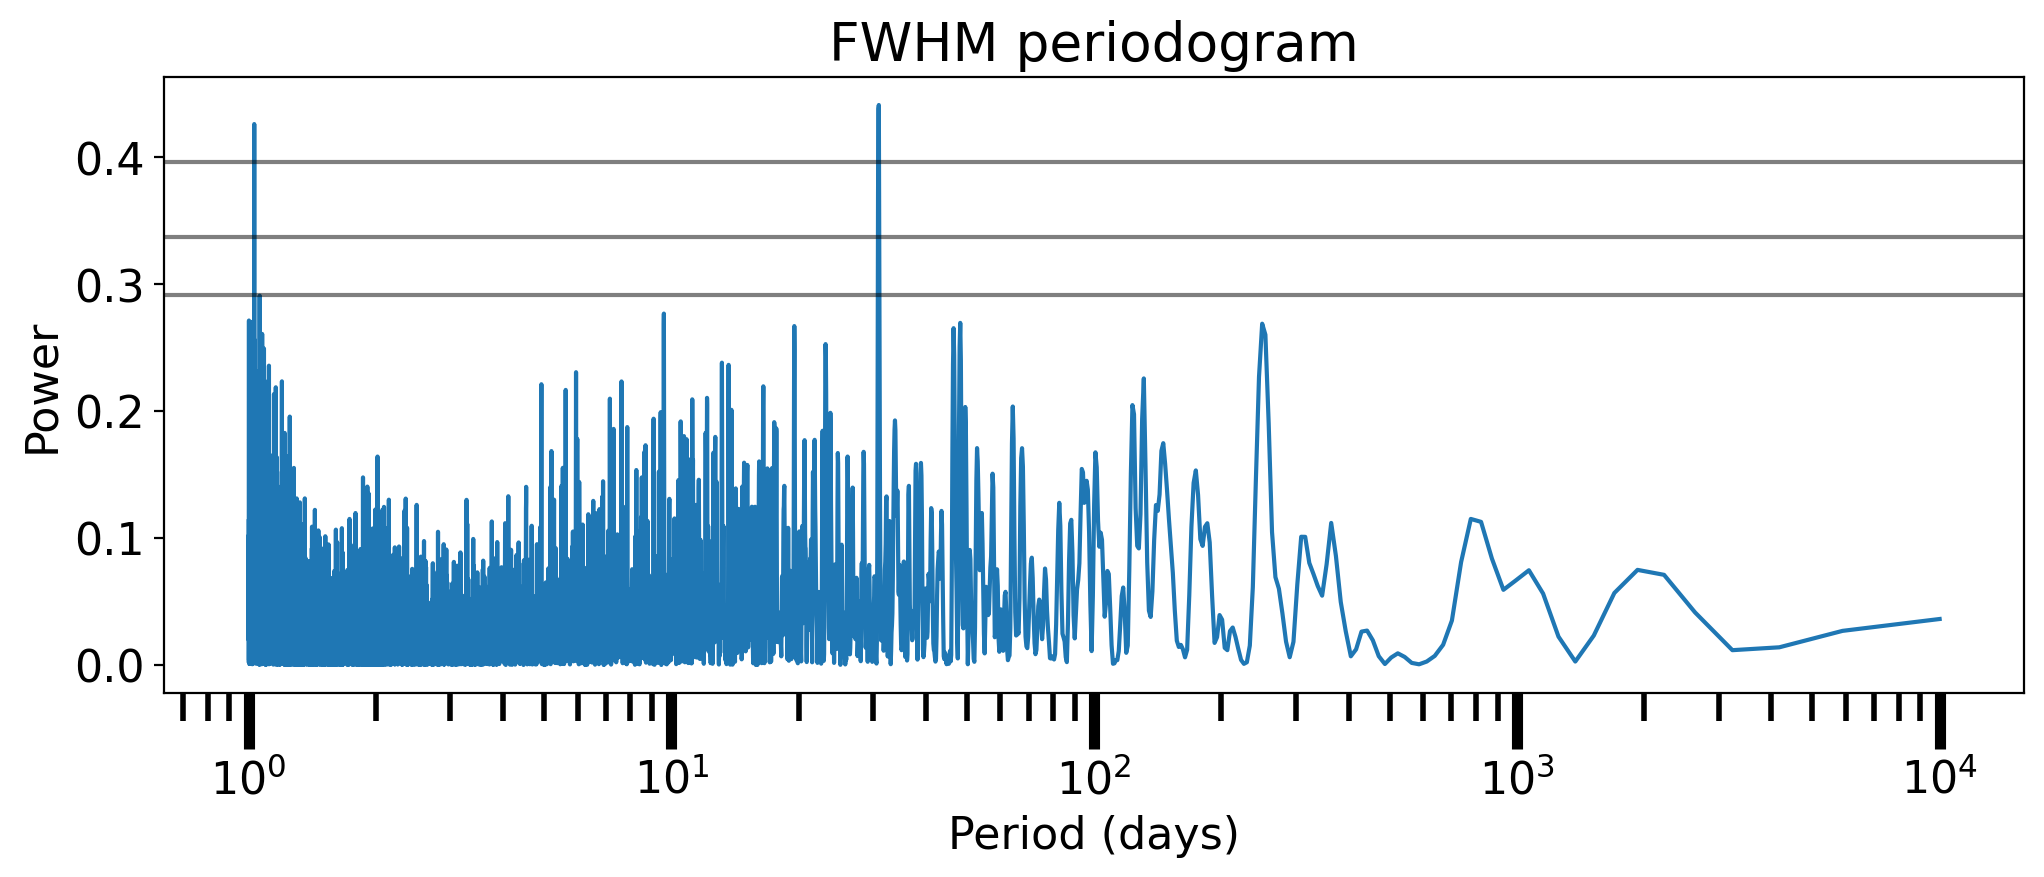

In [13]:
ls = LombScargle(x_rv, fwhm_rv_guess)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('FWHM periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

/Users/mbedell/opt/miniconda3/envs/tesstwin/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


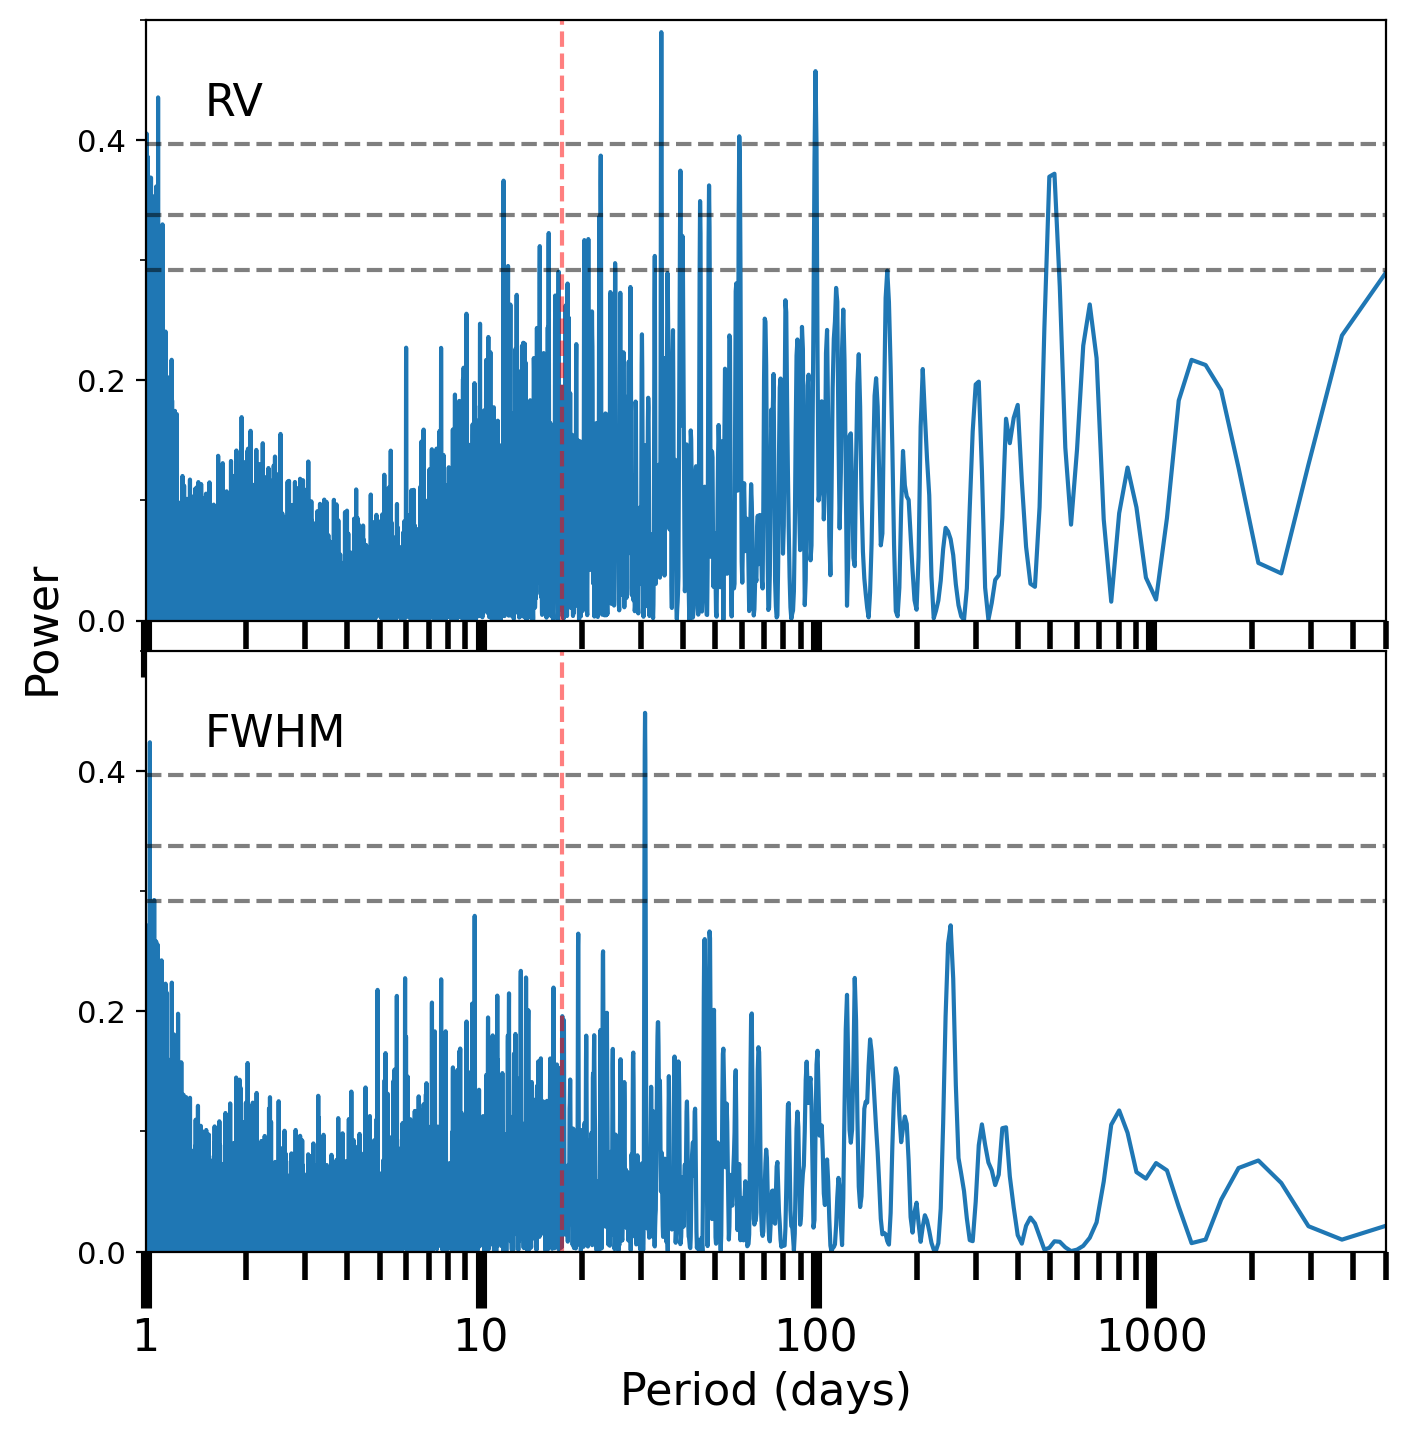

In [14]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

planet_period = 17.47114

ls = LombScargle(x_rv, y_rv_guess, yerr_rv)
freq, power = ls.autopower(minimum_frequency=2.e-4, maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 
ax1.plot(1./freq, power)
for f in fal:
    ax1.axhline(f, c='k', alpha=0.5, ls='--')
ax1.text(1.5, 0.42, 'RV')

power = LombScargle(x_rv, fwhm_rv_guess).power(freq)
fal = ls.false_alarm_level(probabilities) 
ax2.plot(1./freq, power)
for f in fal:
    ax2.axhline(f, c='k', alpha=0.5, ls='--')
ax2.text(1.5, 0.42, 'FWHM')

for ax in (ax1,ax2):
    ax.axvline(planet_period, c='r', alpha=0.5, ls='--')
    ax.set_ylim([0.,0.5])
    ax.set_yticks([0.,0.2,0.4], minor=False)
    ax.set_yticks([0.1,0.3,0.5], minor=True)
    ax.tick_params(labelsize='x-small', axis='y')


ax1.set_xscale('log')
ax1.set_xlim([1.,5.e3])
ax2.set_xlabel('Period (days)')
ax2.set_xticklabels(['0.1','1', '10', '100', '1000'])

fig.text(0.06,0.5,'Power',rotation=90,va='center',ha='center')
plt.subplots_adjust(hspace=0.05)
plt.savefig(plot_dir+'periodograms_harps.pdf');

### Log-likelihood periodogram:
Made by fitting the above activity/instrumental model jointly with a sinusoid at each period in a grid and marginalizing over all terms to get the best possible likelihood at each period.

In [15]:
xs = x_rv
ys = y_rv
ivars = 1./yerr_rv**2

#a, b, c1, c2, d, k, h = param


def design_matrix(P, correlation_with='fwhm'):
    A = np.zeros((len(xs),7))
    A[:,0] = xs**2
    A[:,1] = xs
    A[:,2] = np.invert(pug).astype(int)
    A[:,3] = pug.astype(int)
    if correlation_with is 'fwhm':
        A[:,4] = fwhm_rv
#    elif correlation_with is 'crx':
#        A[:,4] = crx
    A[:,5] = np.sin(2*np.pi / P * xs)
    A[:,6] = np.cos(2*np.pi / P * xs)
    return A

'''
def design_matrix(P, correlation_with='fwhm'):
    A = np.zeros((len(xs),5))
    A[:,0] = np.invert(pug).astype(int)
    A[:,1] = pug.astype(int)
    if correlation_with is 'fwhm':
        A[:,2] = fwhm_rv
    A[:,3] = np.sin(2*np.pi / P * xs)
    A[:,4] = np.cos(2*np.pi / P * xs)
    return A
'''

def loglike(A, param):
    resids = ys - np.dot(A,param)
    return -0.5 * np.sum(resids**2 * ivars)

def best_param(A, cov=True):
    # returns the optimized parameters for a given design matrix A
    # if cov, return a tuple (best_param, cov)
    ATA = np.dot(A.T, ivars[:, None] * A)
    ATy = np.dot(A.T, ivars * ys)
    soln = np.linalg.solve(ATA, ATy)
    if cov:
        return soln, ATA
    return soln

#### log-likelihood periodogram using FWHM correlation:

In [16]:
ps = np.logspace(np.log10(5.),2,num=10000) # period grid
loglikes = np.zeros_like(ps)
solns = np.zeros((len(ps),7))
for i,p in enumerate(ps):
    A = design_matrix(p, correlation_with='fwhm')
    soln, cov = best_param(A)
    solns[i,:] = soln
    loglikes[i] = loglike(A, soln)

In [23]:
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 1

peaks at:
17.07 days
17.07 days
17.06 days
17.08 days
17.06 days
15.91 days
15.92 days
17.08 days
15.91 days
15.92 days


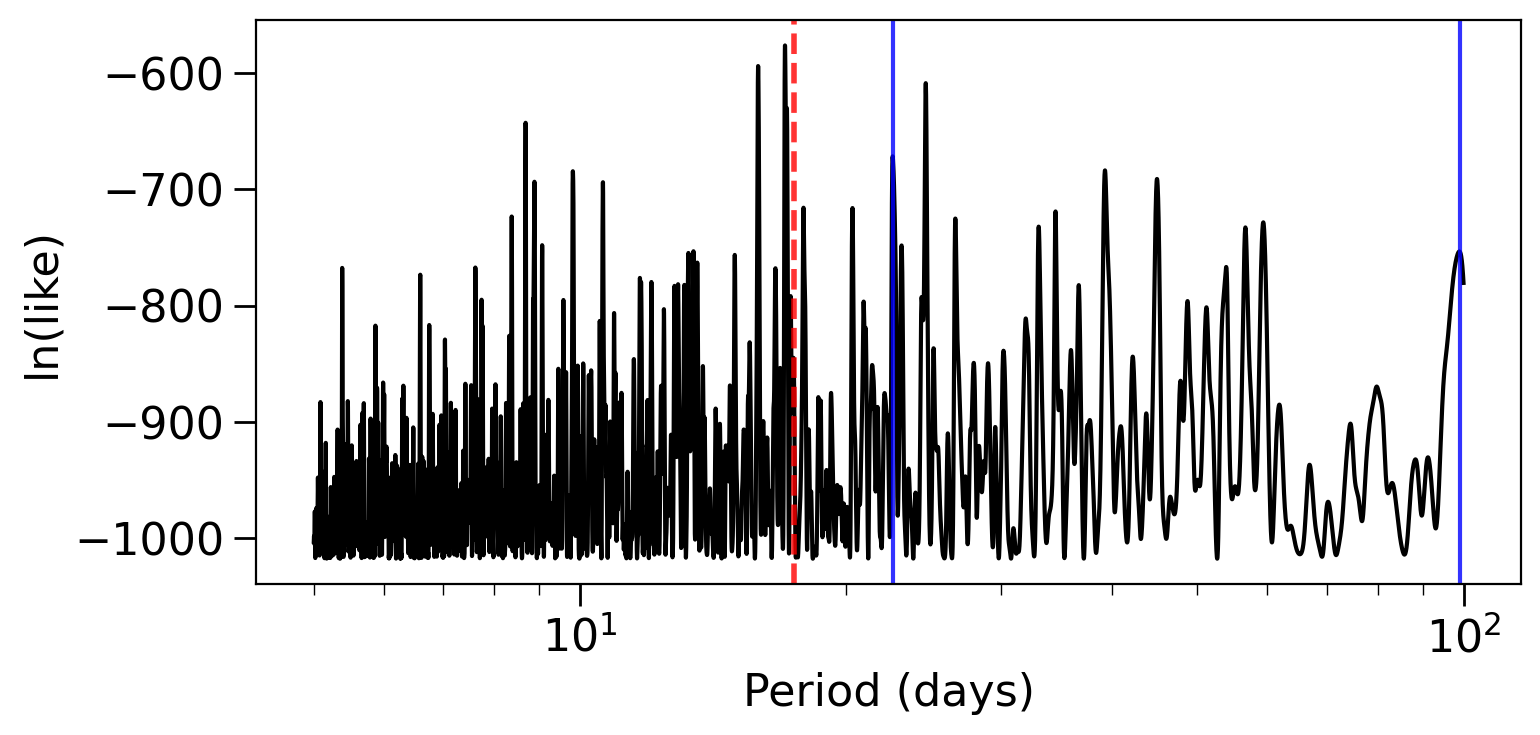

In [24]:
planet_period = 17.47114
activity_periods = [22.6, 99.2]

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(ps, loglikes, color='k')
ax.set_xscale('log')
#ax.set_title('RV likelihood periodogram with FWHM')
ax.set_xlabel('Period (days)')
ax.set_ylabel('ln(like)')
ax.axvline(planet_period, color='r', alpha=0.8, ls='dashed', lw=2)
for p in activity_periods:
    ax.axvline(p, color='b', alpha=0.8)
#ax.text(18,np.max(loglikes)*1.1,'{0:.2f} days'.format(planet_period), color='orange')
print("peaks at:")
sorted_peaks = ps[np.argsort(loglikes)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))
fig.tight_layout()
plt.savefig(plot_dir+'lnlike_periodogram_harps_fwhm.pdf')

In [18]:
ps_small = np.logspace(1,1.5,2000)
loglikes_small = np.zeros_like(ps_small)
solns_small = np.zeros((len(ps_small),7))
covs_small = np.zeros((len(ps_small),7,7))
for i,p in enumerate(ps_small):
    A = design_matrix(p, correlation_with='fwhm')
    soln, cov = best_param(A)
    solns_small[i,:] = soln
    covs_small[i,:,:] = cov
    loglikes_small[i] = loglike(A, soln)

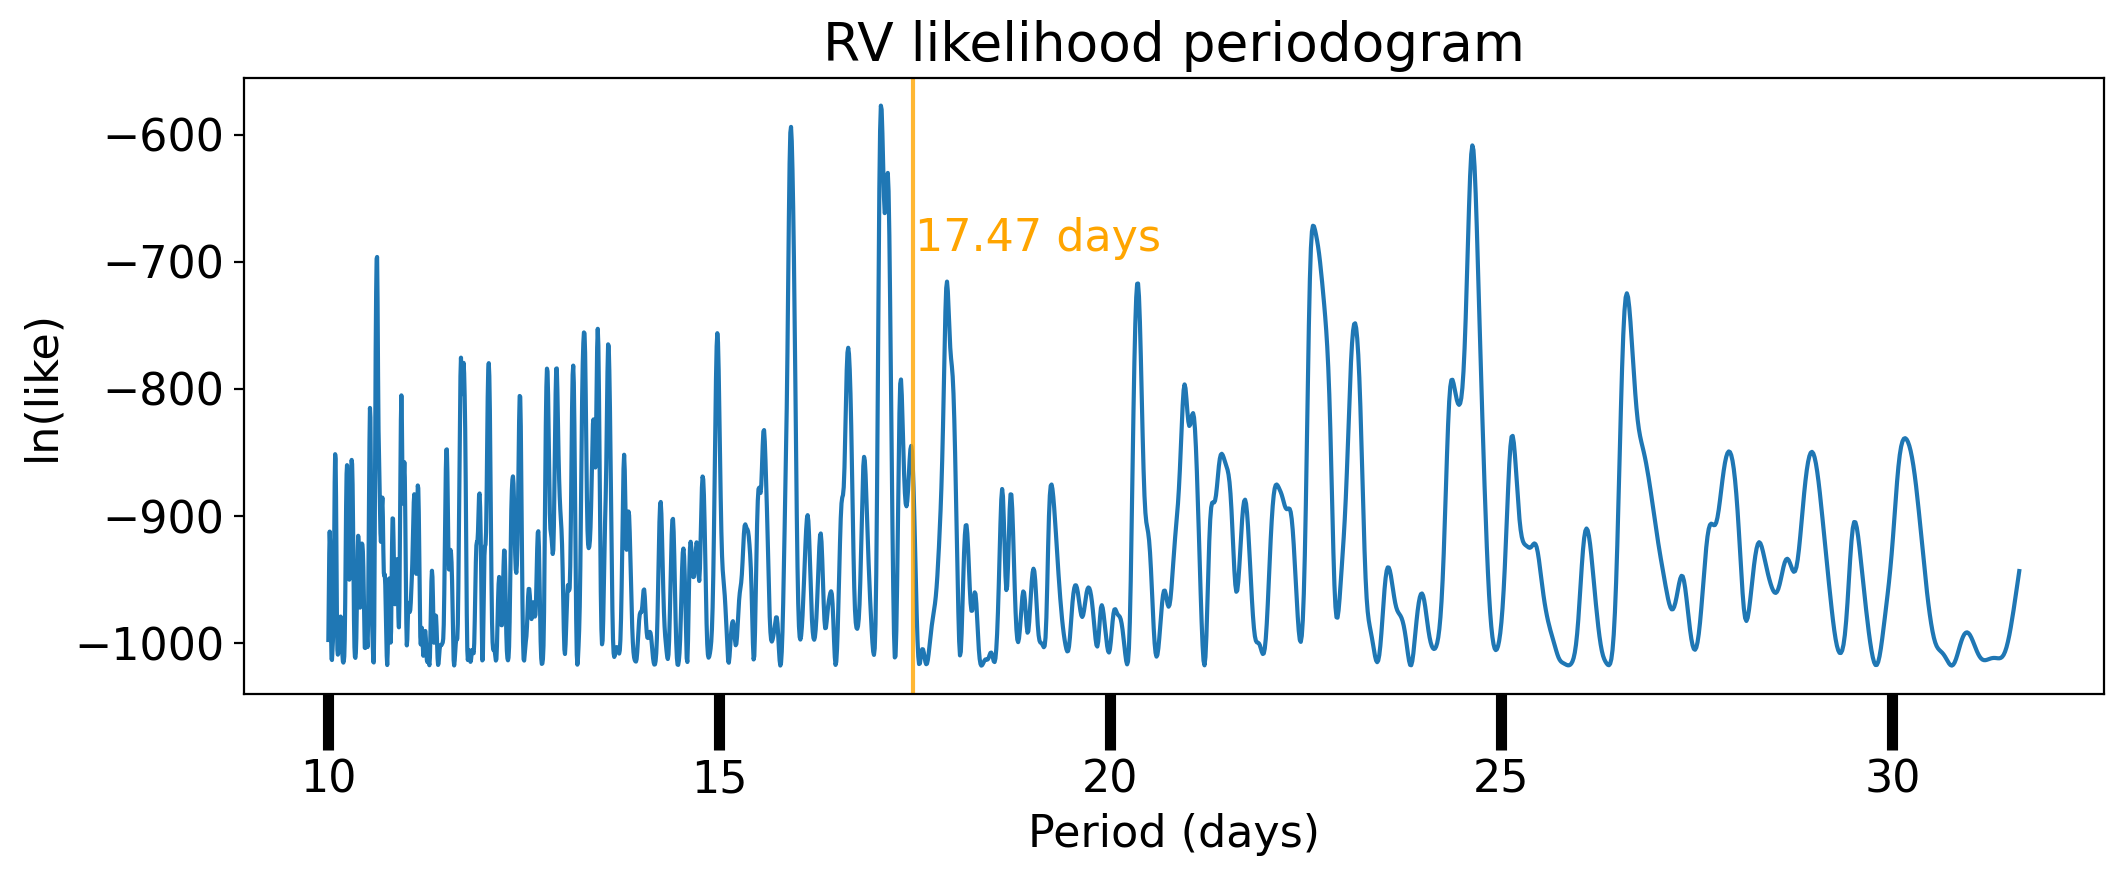

In [19]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(ps_small, loglikes_small)
#ax.set_xscale('log')
ax.set_title('RV likelihood periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('ln(like)')
ax.axvline(planet_period, color='orange', alpha=0.8)
ax.text(17.5,np.max(loglikes)*1.2,'{0:.2f} days'.format(planet_period), color='orange');

#### make a plot for the paper with both periodogram types:

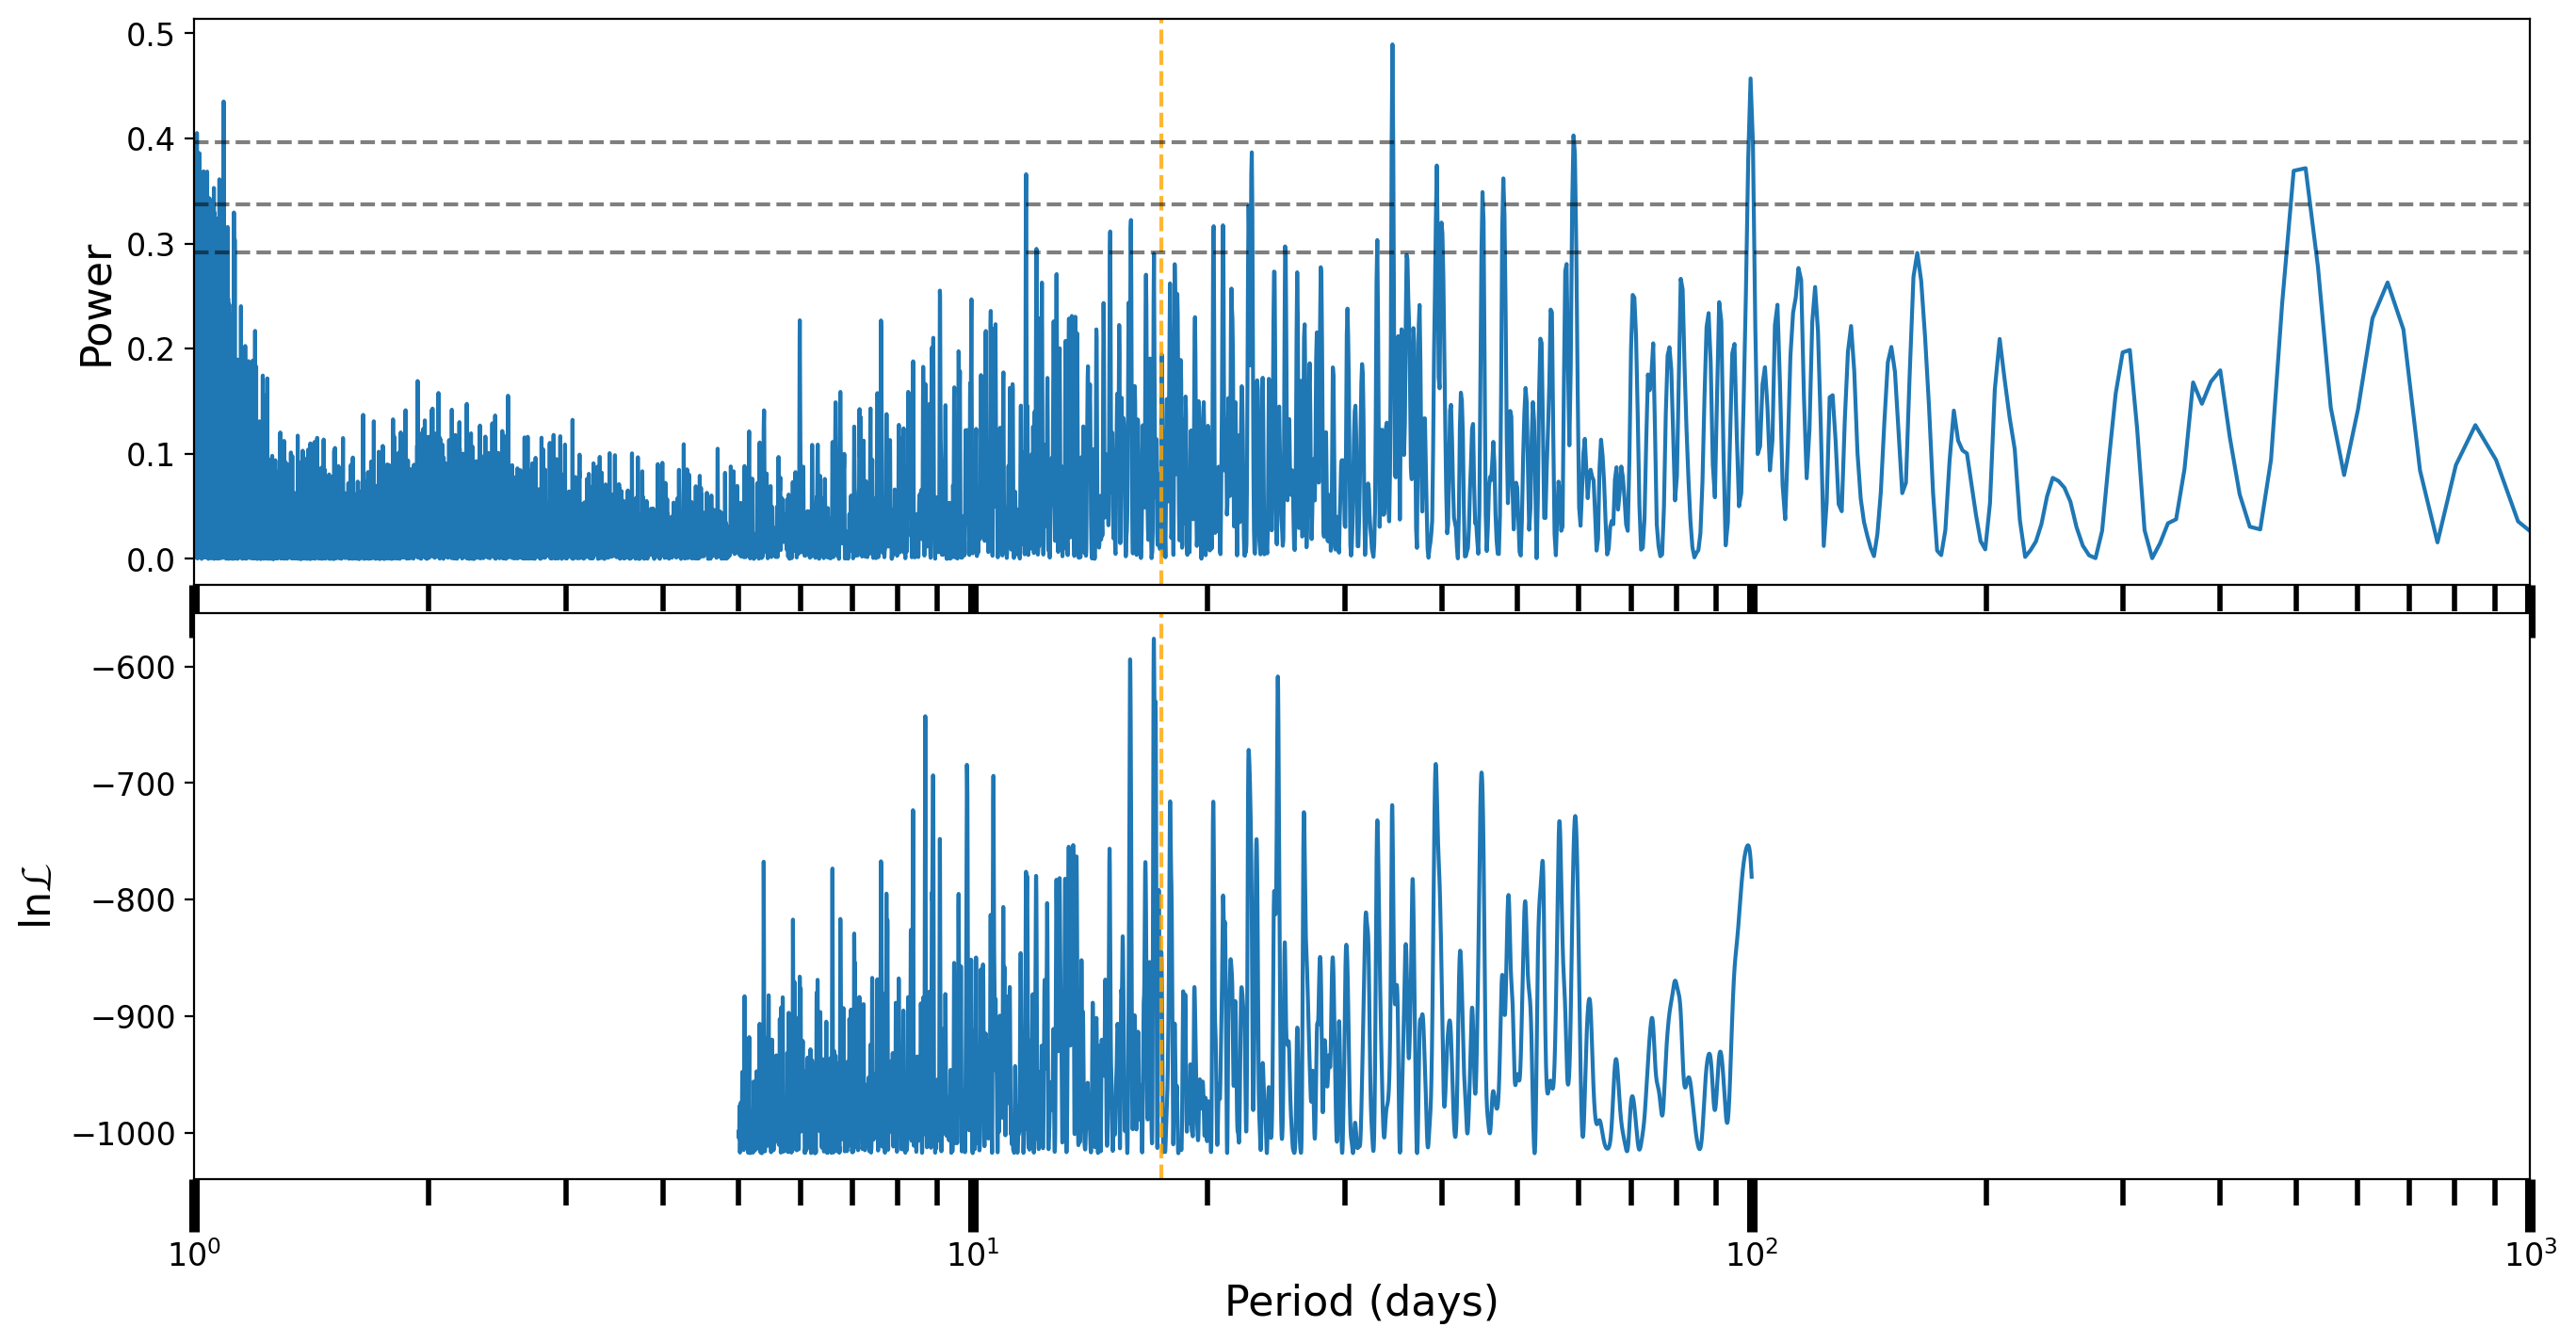

In [20]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(16,8), sharex=True)

ls = LombScargle(x_rv, y_rv_guess, yerr_rv)
freq, power = ls.autopower(minimum_frequency=2.e-4, maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 
ax1.plot(1./freq, power)
ax1.axvline(17.47114, c='orange', alpha=0.8, ls='--')
for f in fal:
    ax1.axhline(f, c='k', alpha=0.5, ls='--')
ax1.set_ylabel('Power')
ax1.set_xlim([1,1e3])


ax2.plot(ps, loglikes)
ax2.set_xscale('log')
ax2.set_xlabel('Period (days)')
ax2.set_ylabel(r'ln$\mathcal{L}$')
ax2.axvline(17.47114, color='orange', alpha=0.8, ls='--')

for ax in (ax1,ax2):
    ax.tick_params(labelsize=12)

plt.subplots_adjust(hspace=0.05)
plt.savefig(plot_dir+'periodograms_harps_fwhm_noquadratic.pdf')